# NB06: When RAG Fails

**Question:** When does retrieval *hurt* performance? Why?

RAG doesn't always help. This notebook investigates the failure modes:
1. **Ceiling effect** — does RAG hurt when the direct baseline is already strong?
2. **Component correlates** — which RAG configurations are most likely to hurt?
3. **Per-question analysis** — on which questions does RAG consistently hurt?
4. **Case studies** — inspect retrieved docs for RAG-hurts cases

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

from analysis_utils import (
    load_all_results, setup_plotting,
    analyze_rag_benefit_distribution, identify_rag_success_factors,
    load_per_item_scores, compute_per_question_rag_delta,
    sample_predictions_with_docs,
    PRIMARY_METRIC, BROKEN_MODELS, MODEL_TIER,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()
print(f"Loaded {len(df)} experiments")


  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)
Loaded 710 experiments


## 1. Ceiling Effect Hypothesis

**H1:** RAG hurts more when the direct baseline is already strong (ceiling effect).

For each model+dataset, plot direct F1 (x) vs RAG delta (y). A negative correlation supports the ceiling hypothesis.

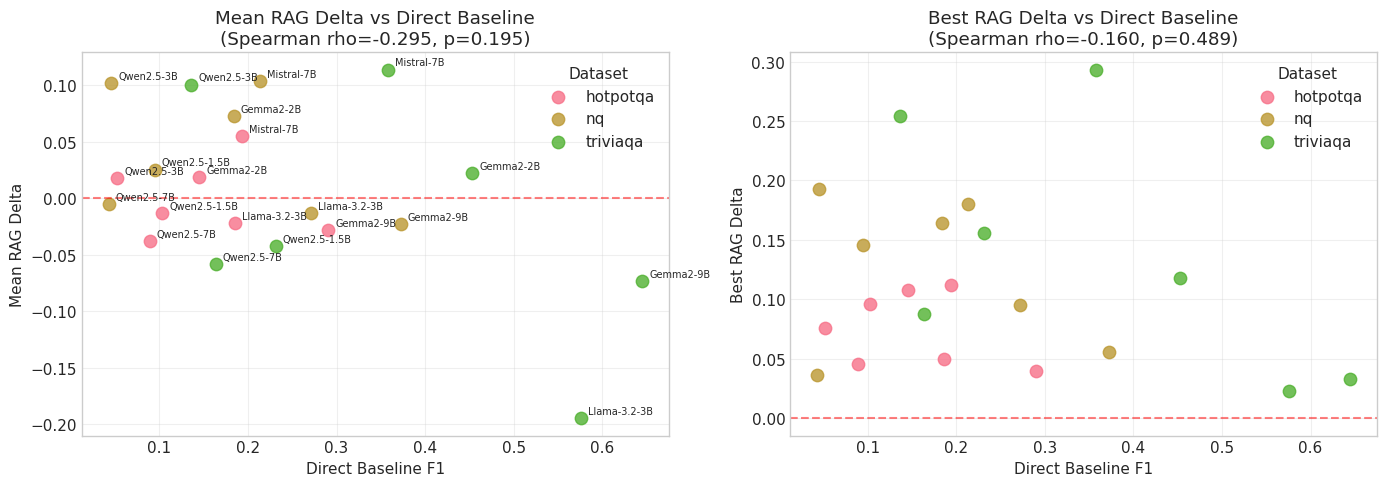


Ceiling effect test (mean delta): rho=-0.295, p=0.195
Ceiling effect test (best delta): rho=-0.160, p=0.489


In [11]:
benefit = analyze_rag_benefit_distribution(df, PRIMARY_METRIC)
rag_df = benefit['rag_df'] if benefit else pd.DataFrame()

if not rag_df.empty and 'direct_baseline' in rag_df.columns:
    # Mean RAG delta per model+dataset
    group_delta = rag_df.groupby(['model_short', 'dataset']).agg(
        mean_delta=('rag_benefit', 'mean'),
        best_delta=('rag_benefit', 'max'),
        worst_delta=('rag_benefit', 'min'),
        direct_baseline=('direct_baseline', 'first'),
        n_configs=('rag_benefit', 'count'),
    ).reset_index()
    group_delta['tier'] = group_delta['model_short'].map(MODEL_TIER)

    # Scatter: direct baseline vs mean RAG delta
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean delta
    ax = axes[0]
    for ds in sorted(group_delta['dataset'].unique()):
        sub = group_delta[group_delta['dataset'] == ds]
        ax.scatter(sub['direct_baseline'], sub['mean_delta'], s=80, label=ds, alpha=0.8)
        for _, row in sub.iterrows():
            ax.annotate(row['model_short'], (row['direct_baseline'], row['mean_delta']),
                        textcoords='offset points', xytext=(5, 3), fontsize=7)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    rho, pval = scipy_stats.spearmanr(group_delta['direct_baseline'], group_delta['mean_delta'])
    ax.set_title(f'Mean RAG Delta vs Direct Baseline\n(Spearman rho={rho:.3f}, p={pval:.3f})')
    ax.set_xlabel('Direct Baseline F1')
    ax.set_ylabel('Mean RAG Delta')
    ax.legend(title='Dataset')
    ax.grid(alpha=0.3)

    # Best delta (optimistic)
    ax = axes[1]
    for ds in sorted(group_delta['dataset'].unique()):
        sub = group_delta[group_delta['dataset'] == ds]
        ax.scatter(sub['direct_baseline'], sub['best_delta'], s=80, label=ds, alpha=0.8)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    rho2, pval2 = scipy_stats.spearmanr(group_delta['direct_baseline'], group_delta['best_delta'])
    ax.set_title(f'Best RAG Delta vs Direct Baseline\n(Spearman rho={rho2:.3f}, p={pval2:.3f})')
    ax.set_xlabel('Direct Baseline F1')
    ax.set_ylabel('Best RAG Delta')
    ax.legend(title='Dataset')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nCeiling effect test (mean delta): rho={rho:.3f}, p={pval:.3f}")
    print(f"Ceiling effect test (best delta): rho={rho2:.3f}, p={pval2:.3f}")
else:
    print("Insufficient data for ceiling effect analysis.")

## 2. Component Correlates of RAG Failure

Which RAG component values are most associated with RAG *hurting* performance?

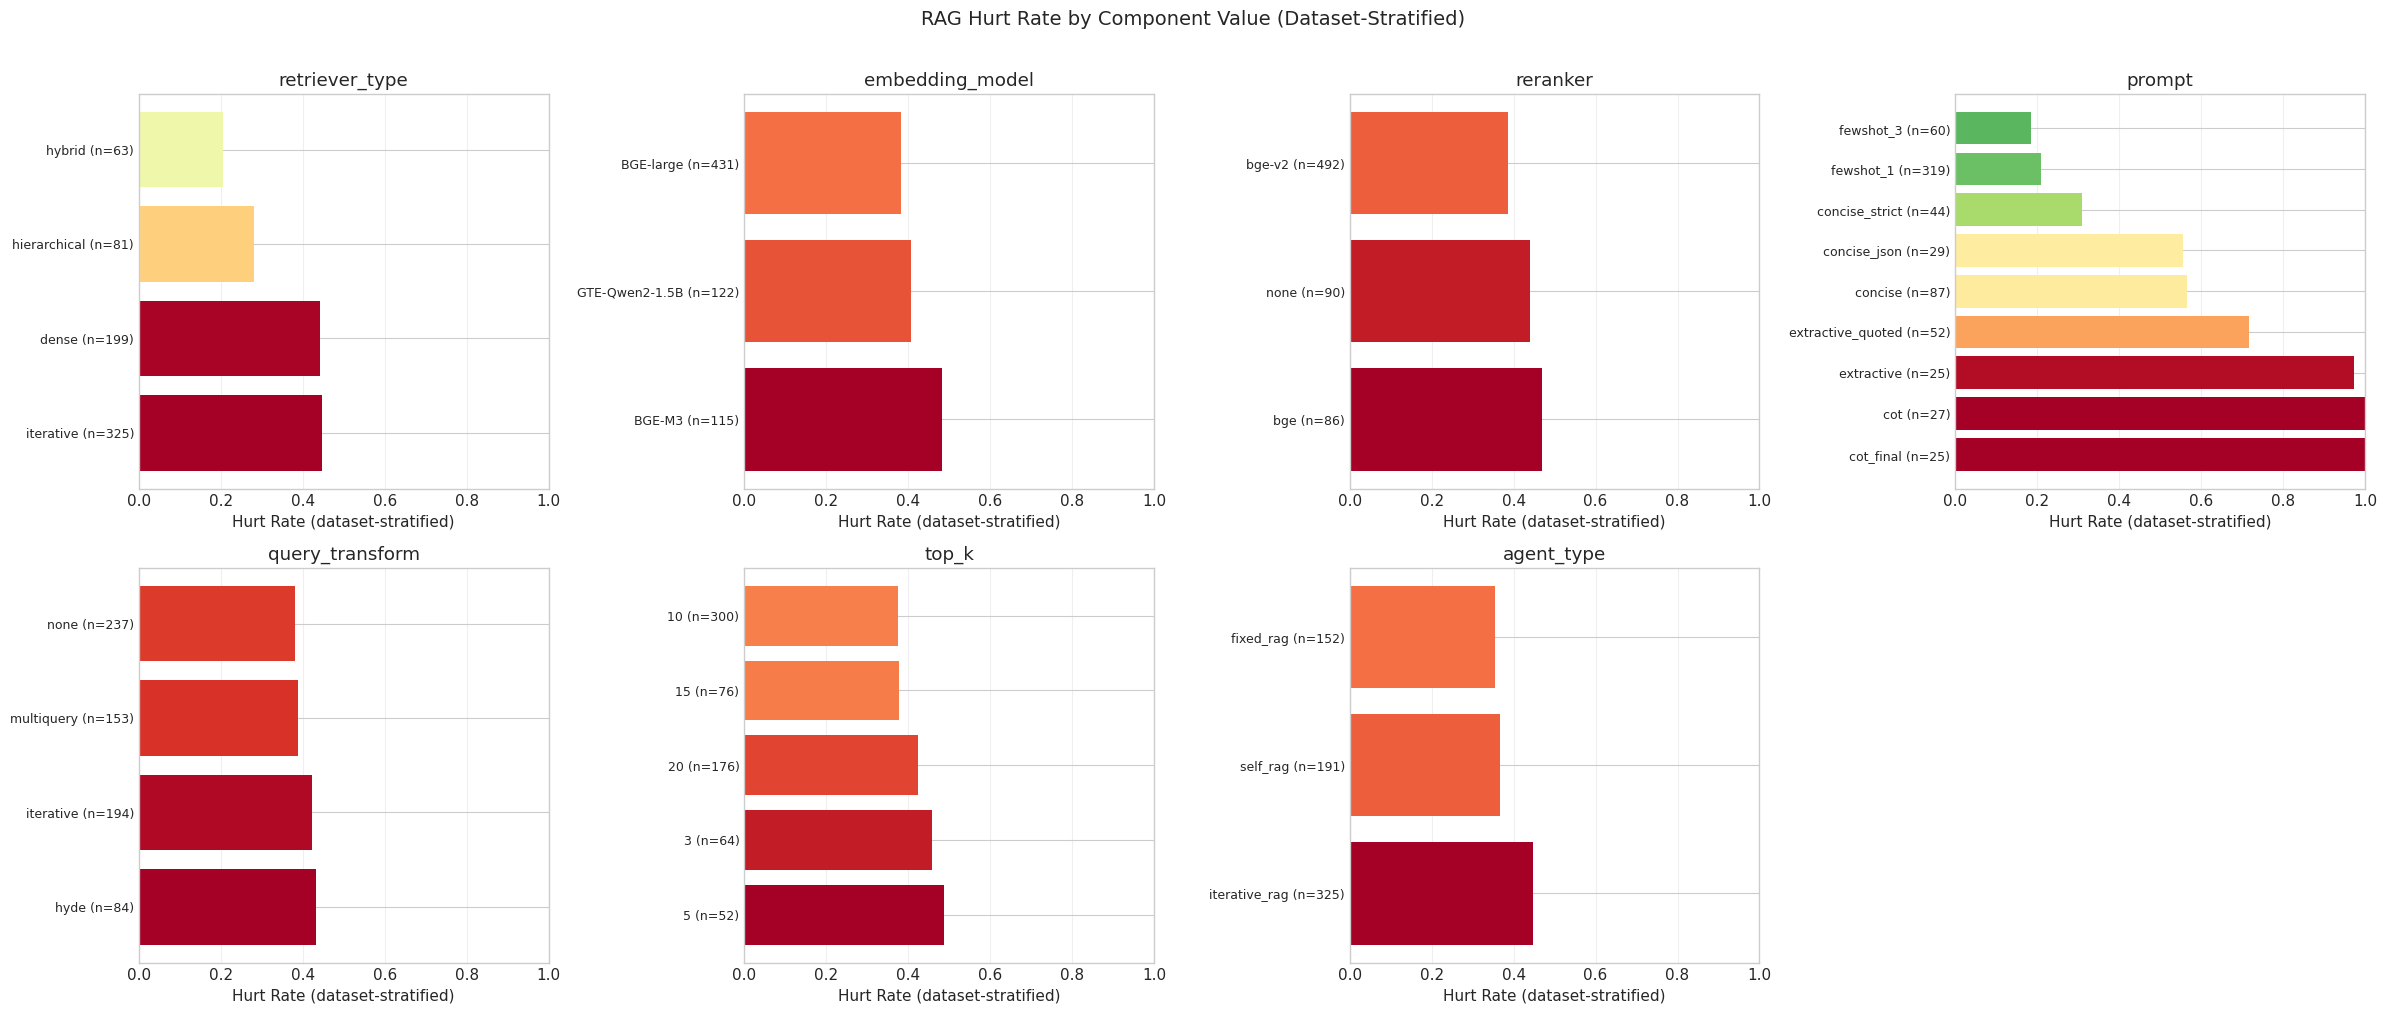

In [12]:
if not rag_df.empty:
    # Binary: did RAG hurt? (> 1 point F1 loss)
    rag_df['rag_hurts_binary'] = (rag_df['rag_benefit'] < -0.01).astype(int)

    factors = ['retriever_type', 'embedding_model', 'reranker', 'prompt',
               'query_transform', 'top_k', 'agent_type']
    factors = [f for f in factors if f in rag_df.columns and rag_df[f].nunique() > 1]

    fig, axes = plt.subplots(2, (len(factors) + 1) // 2,
                             figsize=(6 * ((len(factors) + 1) // 2), 10))
    axes_flat = axes.flatten()

    for idx, factor in enumerate(factors):
        ax = axes_flat[idx]
        # Dataset-stratified: per-(factor, dataset) hurt rate, then average across datasets
        if 'dataset' in rag_df.columns and rag_df['dataset'].nunique() > 1:
            strat = (
                rag_df.groupby([factor, 'dataset'])['rag_hurts_binary']
                .agg(['mean', 'count'])
                .reset_index()
            )
            rates = (
                strat.groupby(factor)
                .agg(hurt_rate=('mean', 'mean'), n=('count', 'sum'))
                .reset_index()
            )
        else:
            rates = rag_df.groupby(factor)['rag_hurts_binary'].agg(['mean', 'count']).reset_index()
            rates.columns = [factor, 'hurt_rate', 'n']
        rates = rates.sort_values('hurt_rate', ascending=False)

        colors = plt.cm.RdYlGn_r(rates['hurt_rate'] / max(rates['hurt_rate'].max(), 0.01))
        ax.barh(range(len(rates)), rates['hurt_rate'], color=colors)
        ax.set_yticks(range(len(rates)))
        ax.set_yticklabels([f"{v} (n={n})" for v, n in zip(rates[factor], rates['n'])],
                           fontsize=9)
        ax.set_xlabel('Hurt Rate (dataset-stratified)')
        ax.set_title(factor)
        ax.set_xlim(0, 1)
        ax.grid(axis='x', alpha=0.3)

    for idx in range(len(factors), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.suptitle('RAG Hurt Rate by Component Value (Dataset-Stratified)', y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()

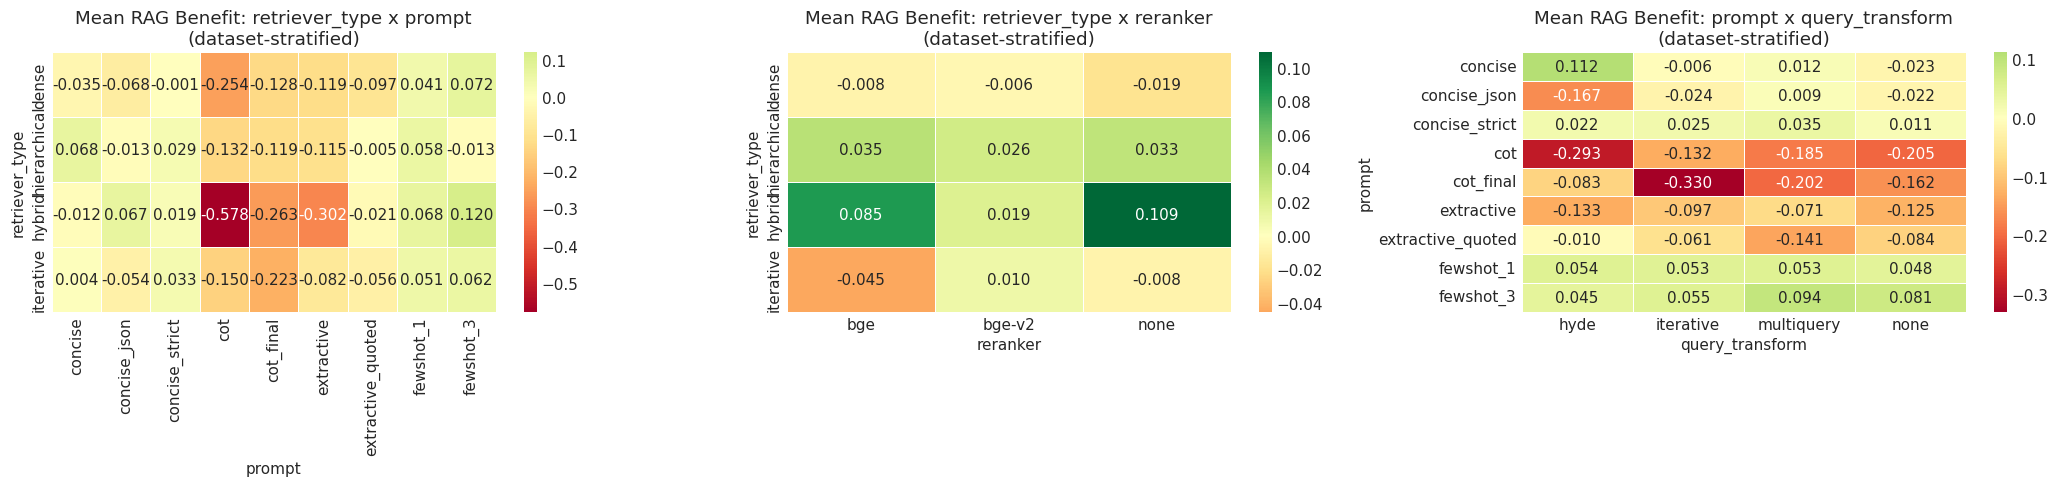

In [13]:
# Mean RAG benefit heatmap: which combos help most / hurt most?
if not rag_df.empty:
    combos = [('retriever_type', 'prompt'), ('retriever_type', 'reranker'),
              ('prompt', 'query_transform')]
    combos = [(f1, f2) for f1, f2 in combos
              if f1 in rag_df.columns and f2 in rag_df.columns
              and rag_df[f1].nunique() > 1 and rag_df[f2].nunique() > 1]

    if combos:
        fig, axes = plt.subplots(1, len(combos), figsize=(7 * len(combos), 5))
        if len(combos) == 1:
            axes = [axes]

        for ax, (f1, f2) in zip(axes, combos):
            # Dataset-stratified: per-(f1, f2, dataset) mean, then average across datasets
            if 'dataset' in rag_df.columns and rag_df['dataset'].nunique() > 1:
                pivot = (
                    rag_df.groupby([f1, f2, 'dataset'])['rag_benefit'].mean()
                    .groupby([f1, f2]).mean()
                    .unstack()
                )
            else:
                pivot = rag_df.groupby([f1, f2])['rag_benefit'].mean().unstack()
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                        center=0, ax=ax, linewidths=0.5)
            ax.set_title(f'Mean RAG Benefit: {f1} x {f2}\n(dataset-stratified)')

        plt.tight_layout()
        plt.show()

## 3. Per-Question RAG Delta

Which questions does RAG consistently hurt across configurations?

In [14]:
# Load per-item scores (this may take a minute for large studies)
print("Loading per-item scores...")
item_scores = load_per_item_scores(STUDY_PATH, metric=PRIMARY_METRIC, include_text=True)
print(f"Loaded {len(item_scores)} per-item scores")
print(f"Experiments: {item_scores['experiment'].nunique()}")
print(f"Questions: {item_scores['idx'].nunique()}")

Loading per-item scores...
Loaded 990000 per-item scores
Experiments: 990
Questions: 1000


Per-question RAG deltas: 906000 rows

Questions where RAG consistently hurts (>80% configs): 15
Questions where RAG consistently helps (>80% configs): 13


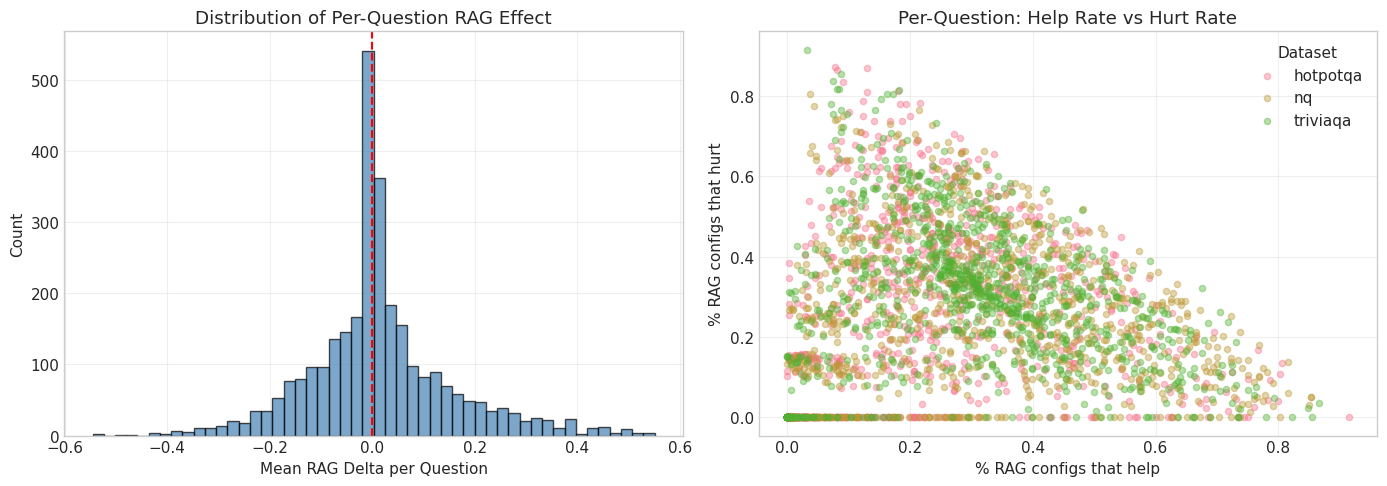

In [15]:
if not item_scores.empty:
    # Filter out broken models
    item_scores = item_scores[~item_scores['model_short'].isin(BROKEN_MODELS)].copy()

    # Compute per-question RAG delta
    rag_delta = compute_per_question_rag_delta(item_scores, PRIMARY_METRIC)
    print(f"Per-question RAG deltas: {len(rag_delta)} rows")

    if not rag_delta.empty:
        # Aggregate: mean delta per question across all RAG configs
        q_agg = rag_delta.groupby(['idx', 'dataset']).agg(
            mean_delta=('rag_delta', 'mean'),
            pct_positive=('rag_delta', lambda x: (x > 0.01).mean()),
            pct_negative=('rag_delta', lambda x: (x < -0.01).mean()),
            n_configs=('rag_delta', 'count'),
        ).reset_index()

        # Distribution of mean per-question delta
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(q_agg['mean_delta'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].axvline(x=0, color='red', linestyle='--')
        axes[0].set_xlabel('Mean RAG Delta per Question')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Distribution of Per-Question RAG Effect')
        axes[0].grid(alpha=0.3)

        # Questions where RAG hurts > 80% of configs
        consistently_hurts = q_agg[q_agg['pct_negative'] > 0.8]
        consistently_helps = q_agg[q_agg['pct_positive'] > 0.8]
        print(f"\nQuestions where RAG consistently hurts (>80% configs): {len(consistently_hurts)}")
        print(f"Questions where RAG consistently helps (>80% configs): {len(consistently_helps)}")

        # Scatter: pct_positive vs pct_negative
        for ds in sorted(q_agg['dataset'].unique()):
            sub = q_agg[q_agg['dataset'] == ds]
            axes[1].scatter(sub['pct_positive'], sub['pct_negative'],
                            s=20, alpha=0.4, label=ds)
        axes[1].set_xlabel('% RAG configs that help')
        axes[1].set_ylabel('% RAG configs that hurt')
        axes[1].set_title('Per-Question: Help Rate vs Hurt Rate')
        axes[1].legend(title='Dataset')
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [16]:
# Top questions where RAG consistently hurts
if not rag_delta.empty:
    worst_questions = q_agg.nsmallest(20, 'mean_delta')
    print("Top 20 questions where RAG hurts most (mean delta across all configs):")
    print("=" * 80)

    for _, row in worst_questions.iterrows():
        # Look up the question text
        q_text_rows = item_scores[
            (item_scores['idx'] == row['idx']) & (item_scores['dataset'] == row['dataset'])
        ]
        q_text = q_text_rows['question'].iloc[0] if 'question' in q_text_rows.columns and len(q_text_rows) > 0 else 'N/A'
        print(f"\n  [{row['dataset']}] Q{row['idx']}: {q_text[:120]}")
        print(f"    Mean delta: {row['mean_delta']:.4f}, "
              f"Hurts in {row['pct_negative']*100:.0f}% of configs")

Top 20 questions where RAG hurts most (mean delta across all configs):

  [triviaqa] Q963: In which year did it become compulsory to wear seat belts in front seats of cars in the UK?
    Mean delta: -0.5458, Hurts in 77% of configs

  [triviaqa] Q144: Who succeeded Brezhnev as Soviet premier?
    Mean delta: -0.5309, Hurts in 84% of configs

  [triviaqa] Q194: Which Palestinian co-founded al Fatah in 1957?
    Mean delta: -0.4839, Hurts in 82% of configs

  [triviaqa] Q591: In which year did the first episode of Minder take place?
    Mean delta: -0.4602, Hurts in 54% of configs

  [triviaqa] Q408: What is the name given to the largest bee in a hive?
    Mean delta: -0.4308, Hurts in 72% of configs

  [nq] Q39: who has the power (judicial) to make decisions in courts of law
    Mean delta: -0.4270, Hurts in 81% of configs

  [hotpotqa] Q809: Radha Jayalakshmi and the Priya sisters were both duo's in what music style? 
    Mean delta: -0.4203, Hurts in 74% of configs

  [nq] Q632: when 

## 4. Case Studies: Inspecting Retrieved Docs

For the worst RAG-hurts questions, inspect what the retriever brought back.

In [17]:
# Pick a few experiments where RAG hurt on specific questions
if not rag_delta.empty:
    # Find a representative RAG experiment that hurt on the worst question
    worst_q = worst_questions.iloc[0]
    hurting_exps = rag_delta[
        (rag_delta['idx'] == worst_q['idx'])
        & (rag_delta['dataset'] == worst_q['dataset'])
        & (rag_delta['rag_delta'] < -0.05)
    ].nsmallest(3, 'rag_delta')

    print(f"Inspecting worst RAG-hurts case:")
    print(f"  Question idx={worst_q['idx']}, dataset={worst_q['dataset']}")
    print(f"  Mean delta={worst_q['mean_delta']:.4f}\n")

    for _, exp_row in hurting_exps.iterrows():
        exp_name = exp_row['experiment']
        preds = sample_predictions_with_docs(
            STUDY_PATH, exp_name,
            indices=[int(worst_q['idx'])]
        )
        if not preds:
            continue

        p = preds[0]
        print(f"  Experiment: {exp_name}")
        print(f"  Question:   {p.get('question', 'N/A')[:200]}")
        print(f"  Expected:   {p.get('expected', 'N/A')}")
        print(f"  Prediction: {p.get('prediction', 'N/A')[:200]}")

        docs = p.get('retrieved_docs', [])
        if docs:
            print(f"  Retrieved docs ({len(docs)}):")
            for doc in docs[:3]:
                content = doc.get('content', '')[:150]
                score = doc.get('score', 'N/A')
                print(f"    [{score:.3f}] {content}...")
        print()

Inspecting worst RAG-hurts case:
  Question idx=963, dataset=triviaqa
  Mean delta=-0.5458

  Experiment: self_gemma29bI_triviaqa_98210303
  Question:   In which year did it become compulsory to wear seat belts in front seats of cars in the UK?
  Expected:   ['one thousand, nine hundred and eighty-three', '1983']
  Prediction:  1976

  Retrieved docs (3):
    [0.995] following events occurred in March 1976: March 1, 1976 (Monday)
The House of Commons of the United Kingdom voted, 249 to 139, to make the wearing of s...
    [0.948] front seat belts with retractors became standard. 1966–1969...
    [0.941] belts in all passenger vehicles starting in 1968. Until the 1980s, three-point belts were commonly available only in the front outboard seats of cars;...

  Experiment: iterative_Llama323BI_triviaqa_d42672b9
  Question:   In which year did it become compulsory to wear seat belts in front seats of cars in the UK?
  Expected:   ['one thousand, nine hundred and eighty-three', '1983']
  Pre

ValueError: Unknown format code 'f' for object of type 'str'

## 5. RAG Failure Patterns by Dataset

Is RAG failure more common on certain question types?

In [ ]:
if not rag_delta.empty:
    # Per-dataset: what fraction of questions are consistently hurt by RAG?
    ds_summary = q_agg.groupby('dataset').agg(
        n_questions=('idx', 'count'),
        mean_delta=('mean_delta', 'mean'),
        pct_mostly_hurt=('pct_negative', lambda x: (x > 0.5).mean()),
        pct_mostly_help=('pct_positive', lambda x: (x > 0.5).mean()),
    ).reset_index()

    print("RAG Failure Patterns by Dataset:")
    display(ds_summary.round(3))

    # Violin plot of mean_delta by dataset
    fig, ax = plt.subplots(figsize=(8, 5))
    datasets = sorted(q_agg['dataset'].unique())
    data_for_violin = [q_agg[q_agg['dataset'] == ds]['mean_delta'].values for ds in datasets]
    parts = ax.violinplot(data_for_violin, showmeans=True, showmedians=True)
    ax.set_xticks(range(1, len(datasets) + 1))
    ax.set_xticklabels(datasets)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Mean RAG Delta per Question')
    ax.set_title('Per-Question RAG Effect Distribution by Dataset')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Summary

Key findings on RAG failure modes:
- Whether the ceiling effect hypothesis is supported
- Which component configurations predict RAG failure
- What fraction of questions are consistently hurt by RAG
- Common patterns in retrieved documents for RAG-hurts cases